In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")

Lagrange (generic function with 1 method)

In [2]:
# Two-step Adams Bashforth Scheme (Explicit)

function ab2(f, tspan, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(N + 1, 1)
    y[1] = y0
    k1=h*f(t[1], y[1])
    k2=h*f(t[1]+h, y[1]+k1)
    y[2]=y[1]+0.5*(k1+k2)
    # Two -step AB steps
    for i in 1:(N-1)
        y[i + 2] = y[i + 1] + (3/2) *h* f(t[i+1], y[i+1]) - 0.5 *h* f(t[i], y[i])
    end

    return t, y
end

ab2 (generic function with 1 method)

In [11]:
function ridc_step(f, tspan, y0 , N)
    
 
    K = 2
    
    h = (tspan[2] - tspan[1]) / N
    
    # Embedding AB-2 into RIDC
    # AB-2 update takes the form 
    # y_(n+1)= y_n + (3/2)*h*f(t_n, y_n) - (1/2)*h*f(t_(n-1), y_(n-1)).
    
    y=zeros(1, N+1, K+1)
    
    t, y[1, :, 1]=ab2(f, tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        y[1, 1, k+1]=y0 # initial condition
        nfval=f(t, y[1, :, k]) # New function value
        
        # (2k+2) equi-spaced nodes are used where k is the iteration number. 
        
        # First step computed by Trapezoidal RK2 (Explicit)
        Qdr=Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[1], t[2]) # Quadrature
        k1= h*(f(t[1], y[1, 1, k+1])- f(t[1], y[1, 1, k]))
        k2= h*(f(t[1] + h, y[1, 1, k+1] + k1 + Qdr) - f(t[1]+h, y[1, 2, k])) 
        
        y[1, 2, k+1]=y[1, 1, k+1] + k1/2 + k2/2 + Qdr
        
        
        
        # First nth steps
        for n in 3:(2*k+1)
            Q= Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-1], t[n])
            b1= (3/2)* h*(f(t[n-1], y[1, n-1, k+1]) - f(t[n-1], y[1, n-1, k]))
            b2= (1/2)* h*(f(t[n-2], y[1, n-2, k+1]) - f(t[n-2], y[1, n-2, k]))
            y[1, n, k+1]= y[1, n-1, k+1] + b1 - b2 + Q
        end
        
        for j in (2*k+2):(N+1)
            Q = Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-1], t[j])
            b1= (3/2)* h*(f(t[j-1], y[1, j-1, k+1]) - f(t[j-1], y[1, j-1, k]))
            b2= (1/2)* h*(f(t[j-2], y[1, j-2, k+1]) - f(t[j-2], y[1, j-2, k]))
            y[1, j, k+1]= y[1, j-1, k+1] + b1 - b2 + Q
        end
            
    end
    return y[1, N+1, K+1]
end

ridc_step (generic function with 1 method)

p= 5.872292831539276


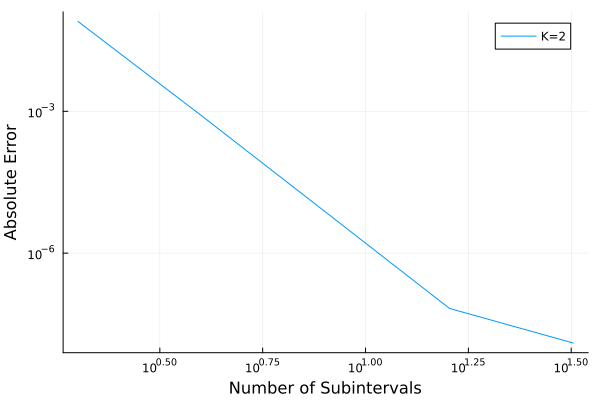

In [4]:
# Example 1: y'=lambda* y, y(0)=1; T in [0, T]
using Plots

y0=1.0

lambda= 1

tspan=[0 10]


f(t, y) = lambda * y



# Exact Solution

exact = y0 * exp(lambda * tspan[2])

p=5

q=5

err=zeros(1, q)

nsub=zeros(q)

for n=1:p
    
    N= 12*n
    
    for j= 1:q
        
        ns = 2^j # Number of subinterval
        
        nsub[j]=ns
    
        ds = tspan[2] / ns # final time / # of subinterval

        y0= 1.0
        
        y=y0
        
        for i in 1:ns
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err[1, j]=abs(exact-y)
        
    end
end
    

# Compute order of convergence and error plot
pdeg = polyfit(log10.(nsub[:]), log10.(err[1, :]),1)
print("p= ",abs(pdeg[2]),"\n") 
plot(nsub, err[1, :], xaxis=:log, yaxis=:log, label="K=2", xlabel="Number of Subintervals", ylabel="Absolute Error")

p= 6.030745669642312


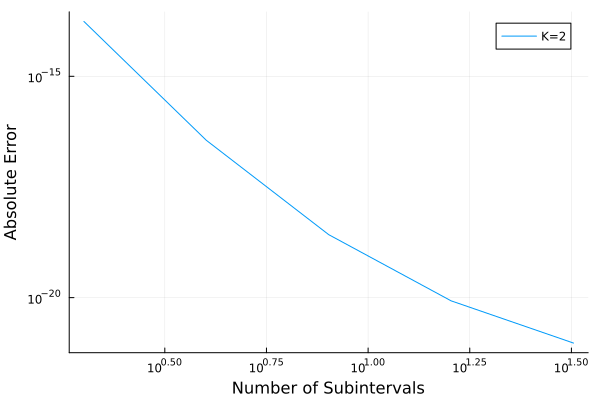

In [5]:
# Example 2: y'=lambda* y, y(0)=1; T in [0, T]
using Plots

y0=1.0

lambda= -1

tspan=[0 25]


f(t, y) = lambda * y



# Exact Solution

exact = y0 * exp(lambda * tspan[2])

p=6
q=5

err=zeros(1, q)

nsub=zeros(q)

for n=1:p
    
    N= 10*n
    
    for j= 1:q
        
        ns = 2^j # Number of subinterval
        
        nsub[j]=ns
    
        ds = tspan[2] / ns # final time / # of subinterval

        y0 = 1.0
        
        y = y0
        
        for i in 1:ns
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err[1, j]=abs(exact-y)
        
    end
end
    

# Compute order of convergence and error plot
pdeg = polyfit(log10.(nsub[:]), log10.(err[1, :]),1)
print("p= ",abs(pdeg[2]),"\n") 
plot(nsub, err[1, :], xaxis=:log, yaxis=:log, label="K=2", xlabel="Number of Subintervals", ylabel="Absolute Error")

p= 5.8672645640504735


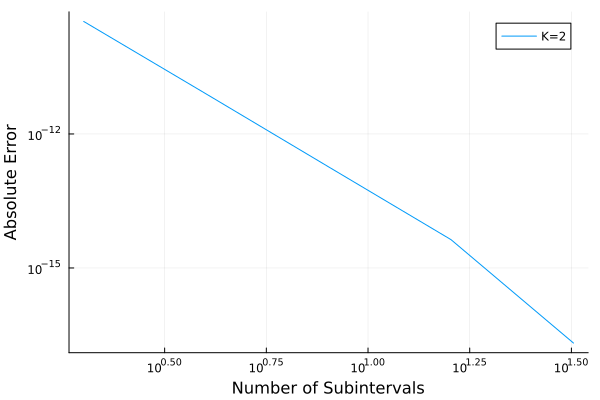

In [12]:
# Example 3: y'=  - y^2, y(0)=1; T in [0, T]
using Plots

y0=1.0



tspan=[0 35]


f(t, y) = - y .^ 2 



# Exact Solution

exact = 1/(1+tspan[2])

p=12
q=5

err=zeros(1, q)

nsub=zeros(q)

for n=1:p
    
    N= 25*n
    
    for j= 1:q
        
        ns = 2^j # Number of subinterval
        
        nsub[j]=ns
    
        ds = tspan[2] / ns # final time / # of subinterval

        y0 = 1.0
        
        y = y0
        
        for i in 1:ns
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err[1, j]=abs(exact-y)
        
    end
end
    

# Compute order of convergence and error plot
pdeg = polyfit(log10.(nsub[:]), log10.(err[1, :]),1)
print("p= ",abs(pdeg[2]),"\n") 
plot(nsub, err[1, :], xaxis=:log, yaxis=:log, label="K=2", xlabel="Number of Subintervals", ylabel="Absolute Error")